In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, y_region_of_interest, color=[255,0,0], thickness=16):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates th8e image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    lines = average_extrapolate_lines(lines, img.shape[0], y_region_of_interest)

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, y_region_of_interest):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines, y_region_of_interest)
    return line_img

# Lines whose absolute value of the slope is above a threshold value
# are averaged to a left_line and right_line. 
# Both lines are extrapolated in the area bottom to top of the region of interest
def average_extrapolate_lines(lines, y_b, y_roi):
    new_lines = []
    ms_p = []
    bs_p = []
    ms_n = []
    bs_n = []

    # step 1: Loop through all lines, calculate slope and y-intercept 
    # and calculate average slope and y-intercept for all lines 
    # whose absolute value of the slope exceeds a certain minimum value
    for line in lines:
        for x1,y1,x2,y2 in line:
            # slope: m
            m = (y2-y1)/float(x2-x1)
            # y-intercept: b
            b = (y1*x2-y2*x1)/float(x2-x1)
            
            # average over lines that are steep enough
            if 1.0>abs(m)>0.5:
                if m>0.5:
                    ms_p.append(m)
                    bs_p.append(b)
                    
                if m<-0.5:
                    ms_n.append(m)
                    bs_n.append(b)
                
    # average slope: positiv = mp_a, negativ = mn_a
    # average y-intercept: positiv = bp_a, negativ = bn_a
    mp_a = np.average(ms_p)  
    bp_a = np.average(bs_p) 
    mn_a = np.average(ms_n)  
    bn_a = np.average(bs_n)
    
    # step 2: Calculate the intersection of the straight line equation 
    # with the bottom and the top of the region of interest
    
    # x-value of the bottom y_b of the region of interest: positiv = xp_b, negativ = xb_b
    xp_b = int(round((y_b-bp_a)/mp_a))
    xn_b = int(round((y_b-bn_a)/mn_a))
    
    # x-value of the top y_roi of the region of interest: positiv = xp_b, negativ = xb_b
    xp_roi = int(round((y_roi-bp_a)/mp_a))
    xn_roi = int(round((y_roi-bn_a)/mn_a))
    
    # step 3: Determine the left and right limit-lines of the lanes
    # and return these two as the new list of lines
    
    # averaged and extrapolated left and right line
    left_line = (xp_b,y_b,xp_roi,y_roi)
    right_line = (xn_roi,y_roi,xn_b,y_b)
    
    new_lines.append(left_line)
    new_lines.append(right_line)
    
    new_lines = [np.array(new_lines)]
    return new_lines

#
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [2]:
def process_image(image):
    # pipeline step 1: grayscale the image
    gray = grayscale(image)
    
    # pipeline step 2: Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # pipeline step 3: Define parameters for Canny edge detection and apply
    low_threshold = 50
    high_threshold = 120
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # pipeline step 4: Define region of interest using a four sided polygon to mask
    imshape = image.shape
    delta = 40
    y_region_of_interest = 320
    vertices = np.array([[(0, imshape[0]),(imshape[1]/2-delta,y_region_of_interest),(imshape[1]/2+delta, y_region_of_interest),(imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    
    # pipeline step 5: Define parameters for Hough transformation and apply to identify lines
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 150    # maximum gap in pixels between connectable line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, y_region_of_interest)
    
    # pipeline step 6: Draw the lines on the image
    lines_edges = weighted_img(line_image, image, α=0.8, β=1., λ=0.)
    return lines_edges

imageName(1): solidWhiteCurve.jpg


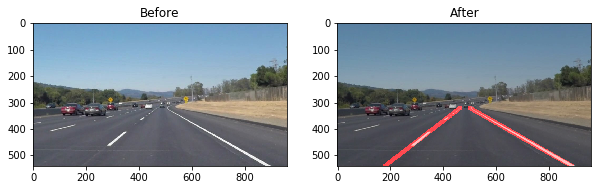

imageName(2): solidWhiteRight.jpg


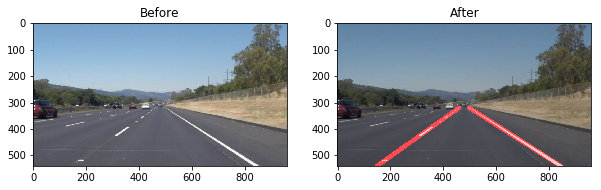

imageName(3): solidYellowCurve.jpg


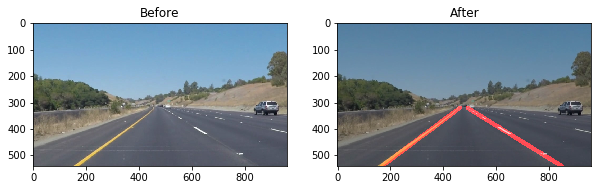

imageName(4): solidYellowCurve2.jpg


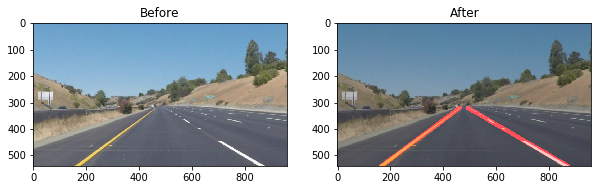

imageName(5): solidYellowLeft.jpg


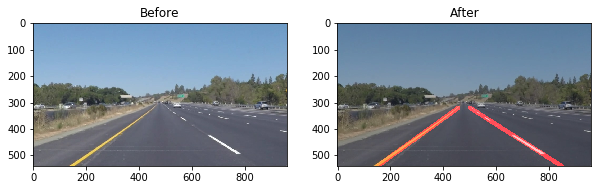

imageName(6): whiteCarLaneSwitch.jpg


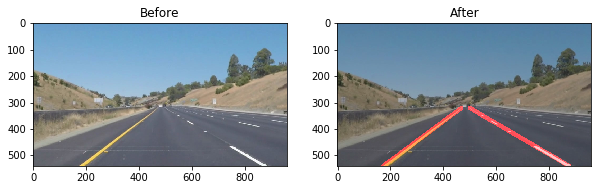

In [3]:
import os
imageNameArray = os.listdir("test_images/")
counter = 0
for imageName in imageNameArray:
    counter += 1
    #reading in an image
    text = 'imageName(' + str(counter) + "): " + imageName
    print(text)
    image = mpimg.imread('test_images/' + imageName)
    
    lines_edges = process_image(image)
    
    fig = plt.figure(figsize=(10,10))

    a=fig.add_subplot(1,2,1)
    plt.imshow(image)
    imgplot = plt.imshow(image)
    a.set_title('Before')

    a=fig.add_subplot(1,2,2)
    imgplot = plt.imshow(lines_edges)
    a.set_title('After')
    
    plt.show()
    cv2.imwrite('test_images_output/' + imageName, lines_edges)
    
    

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [5]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:17<00:00, 38.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 18.5 s


In [6]:
HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(yellow_output))

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip2 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip2.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:05<00:00, 37.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 6.71 s


In [8]:
HTML("""
<video width="640" height="300" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(white_output))